# Prepare libraries

In [1]:
from pathlib import Path
import numpy as np
from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import cv2
import logging
import matplotlib.pyplot as plt
logging.basicConfig(format='%(message)s', level=logging.DEBUG)
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

from data_read_write import read_image, read_dataset
from preprocessing import preprocess
from plotting import showInRow

# Parameters

In [2]:
CLUSTER_TRAIN_DIR = Path("Dataset/Train_cluster")
CLUSTER_LABELS = "Dataset/Train_cluster/labels.csv"

TRAIN_DIR = Path("Dataset/Train")
TRAIN_LABELS_FILE = "Dataset/Train/labels.csv"

TEST_DIR = Path("Dataset/GTSRB/Final_Test/Images")
TEST_LABELS_FILE = "Dataset/GT-final_test.csv"

IMG_SIZE = (64,64)
VOCABULARY_SIZE = 600

IMG_TYPE = "ppm"

# BoVW

In [3]:
class BoVW:
    """
    Bag of visual words model
    """
    def __init__(self, extractor, train_images=None, cluster_model=None, vocabulary_size=5):
        """
        Initialise model and possibly train on data
        Args:
            extractor: model of decsriptors extraction (SIFT for example)
            train_images: array of images
            vocabulary_size: size of visual words vocabulary
        """
        self.extractor = extractor
        self.vocabulary_size = vocabulary_size
        self.train_images = train_images
        self.cluster_model = cluster_model
        self.scaler = StandardScaler()
        self.train_histograms = None
        self.predictor = None
        
        # Train models if train data is available
        if self.train_images is not None:
            print("Training BoVW starts ...")
            print("Extracting descriptors ...")
            train_desc = self._get_images_descriptors(self.train_images)
            if self.cluster_model is None:
                print("Grouping descriptors ...")
                all_descriptors_list = self._get_descriptors_list(train_desc)
                print("Descriptors extracted from tarin images")
                print("Training cluster model ...")
                self._train_cluster_model(all_descriptors_list,vocabulary_size)
                print("Cluster model trained")
            print("Computing histograms ...")
            train_histograms = self._get_histograms(train_desc)
            print("Histograms computed")
            print("Normalizing histograms ...")
            self.scaler.fit(train_histograms)  
            self.train_histograms = self.scaler.transform(train_histograms)
            print("Histograms normalized")
            
            
    
    def _get_image_descriptors(self,image):
        """
        Extract image descriptors from image
        Args:
            image: image to extract descriptors from
        Return:
            keypoints, descriptors extracted from image
        """
        keypoints, descriptors = self.extractor.detectAndCompute(image, None)
        if len(keypoints) < 1 or descriptors is None:
            descriptors = np.zeros((1, self.extractor.descriptorSize()), np.float32)
        return keypoints, descriptors
    
    
    def _get_images_descriptors(self,images):
        """
        Extract image descriptors from array of images
        Args:
            images: array of images to extract descriptors from
        Returns:
            array of extracted descriptors, 1 item for 1 image
        """
        descriptors = []
        
        for image in tqdm(images):
            _, img_features = self._get_image_descriptors(image)
            if img_features is not None:
                descriptors.append(img_features)
        return np.array(descriptors)
        
    def _get_descriptors_list(self, descriptors):
        """
        Stack descriptors in array of shape (n, 128)
        Args:
            descriptors: array of extracted descriptors
        Returns:
            descriptors in array of shape (n, 128)
        """
        stacked_descriptors = np.array(descriptors[0])
        for descriptor in tqdm(descriptors[1:]):
            if descriptor is not None:
                stacked_descriptors = np.vstack((stacked_descriptors, descriptor))
        
        return stacked_descriptors
        
    
    def _train_cluster_model(self, descriptors, cluster_num=2):
        """
        Train K-Means with extracted descriptors to form vocabulary
        Args:
            descriptors: descriptors in array of shape (n, 128)
            cluster_num: Number of visual words in vocabulary
        """
        self.cluster_model = KMeans(n_clusters=cluster_num, verbose=1, init='random', n_init=1).fit(descriptors)
    
    
    def _get_histograms(self, descriptors):
        """
        Produce vocabulary histograms from list of image descriptors
        Args:
            descriptors: array of descriptors extracted from images
        Returns:
            Vocabulary histograms, 1 per image
        """
        histograms = np.zeros((descriptors.shape[0], self.vocabulary_size))
        
        for i in tqdm(range(descriptors.shape[0])):
            for j in range(len(descriptors[i])):
                feature = descriptors[i][j]
                feature = feature.reshape(1, 128)
                idx = self.cluster_model.predict(feature)
                histograms[i][idx] += 1
        return histograms
    
    def get_features(self, dataset):
        print("Extracting descriptors ...")
        descriptors = self._get_images_descriptors(dataset)
        print("Computing histograms ...")
        histograms = self._get_histograms(descriptors)
        print("Normalizing histograms ...")
        features = self.scaler.transform(histograms)
        print("Done")
        return features
            
                
    def plot_histogram(self, histograms):
        """
        Ptot historams
        """
        x_scalar = np.arange(self.vocabulary_size)
        y_scalar = np.array([abs(np.sum(histograms[:,h], dtype=np.int32)) for h in range(self.vocabulary_size)])

        plt.bar(x_scalar, y_scalar)
        plt.xlabel("Visual Word Index")
        plt.ylabel("Frequency")
        plt.title("Complete Vocabulary Generated")
        plt.xticks(x_scalar + 0.4, x_scalar)
        plt.show()
        
    def plot_nearest_neighbours(self, neighbour_ids, distances=None):
        """
        Plot images in row by their ids
        """
        count = len(neighbour_ids)
        plt.figure(figsize=(20,10))
        for i in range(len(neighbour_ids)):
            idx = neighbour_ids[i]
            subplot = plt.subplot(1, count, i+1)
            if distances is not None:
                subplot.set_title("{:10.4f}".format(distances[i]))
      
            img = self.train_images[idx]
            cmap = 'gray' if (len(img.shape) == 2 or img.shape[2] == 1) else None
            subplot.imshow(img, cmap=cmap)
        plt.show()
        
        
    def get_neares_neighbours(self, image, n_neighbours=10):
        """
        Extract nearest neighbours from train dataset for new image with KNN
        Args:
            image: Querry image
            n_neighbours: number of neighbours to retrieve
        Returns:
            2 arrays: distances and ids of neighbours
        """
        
        key_points, descriptor = self._get_image_descriptors(image)
        descriptors = np.array([descriptor])
        
        histograms = self._get_histograms(descriptors)
        histogram = self.scaler.transform(histograms)[0]
        
        knn = NearestNeighbors(n_neighbors=n_neighbours)
        knn.fit(self.train_histograms)
        dists, ids = knn.kneighbors([histogram])
        print("Original image:")
        showInRow([image])
        print("SIFT features:")
        showInRow([cv2.drawKeypoints(image, key_points, image.copy())])
        print("Neares Neighbours:")
        self.plot_nearest_neighbours(ids[0], dists[0])
        return dists, ids
        

# Read data

In [4]:
cluster_X, _ = read_dataset(images_dir=CLUSTER_TRAIN_DIR,
                            labels_file=CLUSTER_LABELS,
                             file_type=IMG_TYPE,
                             img_shape=IMG_SIZE)

train_X, train_y = read_dataset(images_dir=TRAIN_DIR,
                                labels_file=TRAIN_LABELS_FILE,
                                file_type=IMG_TYPE,
                                img_shape=IMG_SIZE)

test_X, test_y = read_dataset(images_dir=TEST_DIR,
                              labels_file=TEST_LABELS_FILE,
                              delimiter=";",
                              file_type=IMG_TYPE,
                              img_shape=IMG_SIZE)
print("Dataset size:")
print("\tTrain: ", train_X.shape[0], "images with shapes ", train_X.shape[1:])
print("\tTest: ", test_X.shape[0], "images with shapes ", test_X.shape[1:])

Dataset size:
	Train:  22198 images with shapes  (64, 64, 3)
	Test:  12630 images with shapes  (64, 64, 3)


# Train BoVW histograms

In [5]:
bovw = BoVW(extractor=cv2.xfeatures2d.SIFT_create(contrastThreshold = 0.02, sigma = 1.2, edgeThreshold = 20),
            train_images=cluster_X, 
            vocabulary_size=VOCABULARY_SIZE)

  1%|▏         | 68/5106 [00:00<00:07, 677.47it/s]

Training BoVW starts ...
Extracting descriptors ...


  5%|▍         | 252/5105 [00:00<00:01, 2513.86it/s]

Grouping descriptors ...


100%|██████████| 5105/5105 [01:10<00:00, 72.10it/s] 


Descriptors extracted from tarin images
Training cluster model ...
Initialization complete
Iteration 0, inertia 34397380608.0
Iteration 1, inertia 24031244288.0
Iteration 2, inertia 23203962880.0
Iteration 3, inertia 22836404224.0
Iteration 4, inertia 22630946816.0
Iteration 5, inertia 22500376576.0
Iteration 6, inertia 22411001856.0
Iteration 7, inertia 22344153088.0
Iteration 8, inertia 22290694144.0
Iteration 9, inertia 22246113280.0
Iteration 10, inertia 22208778240.0
Iteration 11, inertia 22177148928.0
Iteration 12, inertia 22150879232.0
Iteration 13, inertia 22128226304.0
Iteration 14, inertia 22108878848.0
Iteration 15, inertia 22093246464.0
Iteration 16, inertia 22078861312.0
Iteration 17, inertia 22066053120.0
Iteration 18, inertia 22054578176.0
Iteration 19, inertia 22044393472.0
Iteration 20, inertia 22036068352.0
Iteration 21, inertia 22029289472.0
Iteration 22, inertia 22023505920.0
Iteration 23, inertia 22018390016.0
Iteration 24, inertia 22013712384.0
Iteration 25, inert

  0%|          | 2/5106 [00:00<04:31, 18.79it/s]

Cluster model trained
Computing histograms ...


100%|██████████| 5106/5106 [01:46<00:00, 47.72it/s]

Histograms computed
Normalizing histograms ...
Histograms normalized


# Check nearest meighbours

100%|██████████| 1/1 [00:00<00:00, 577.97it/s]


Original image:


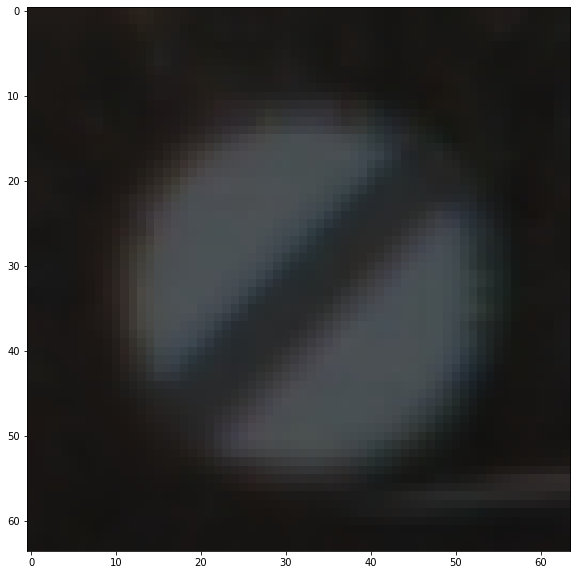

SIFT features:


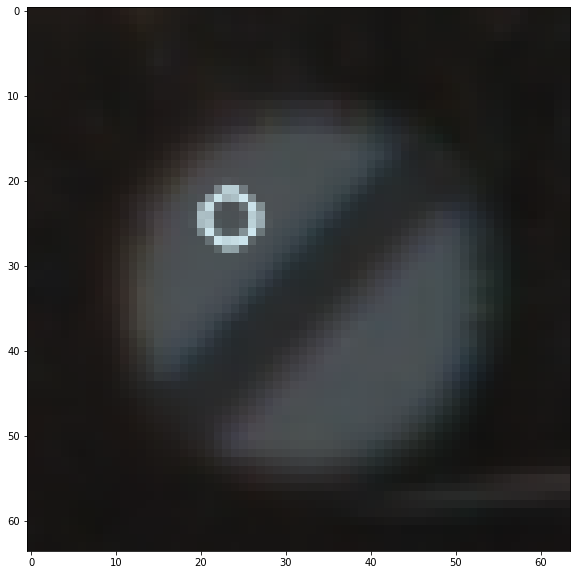

Neares Neighbours:


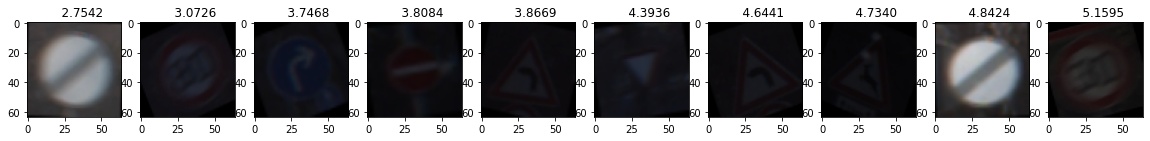

(array([[2.75418658, 3.07257054, 3.74678717, 3.80839192, 3.8668847 ,
         4.39360434, 4.64407469, 4.73396493, 4.84236005, 5.15952352]]),
 array([[2607, 1094, 4691, 3062, 3738, 3943, 4996, 4681, 1871, 3081]]))

In [9]:
test_img = test_X[0]
bovw.get_neares_neighbours(test_img, n_neighbours=10)

# Train Linear SVM

In [10]:
train_features = bovw.get_features(train_X)
train_features = np.float32(train_features).reshape(len(train_features),-1)
train_y = np.float32(train_y)

  0%|          | 49/22198 [00:00<00:45, 486.58it/s]

Extracting descriptors ...


  0%|          | 6/22198 [00:00<06:47, 54.48it/s]

Computing histograms ...


100%|██████████| 22198/22198 [07:23<00:00, 50.04it/s]


Normalizing histograms ...
Done


In [11]:
svm = SVC(kernel='linear', C=1, decision_function_shape='ovo', verbose=True).fit(train_features, train_y)

[LibSVM]

# Testing

In [12]:
test_features = bovw.get_features(test_X)

  1%|          | 73/12630 [00:00<00:17, 726.86it/s]

Extracting descriptors ...


  0%|          | 6/12630 [00:00<03:38, 57.86it/s]

Computing histograms ...


100%|██████████| 12630/12630 [03:01<00:00, 69.56it/s]

Normalizing histograms ...
Done


In [13]:
test_features = np.float32(test_features).reshape(len(test_features),-1)

In [14]:
test_y = np.float32(test_y)

In [15]:
y_pred = svm.predict(test_features)

In [16]:
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix

In [17]:
print(classification_report(y_pred, test_y))

              precision    recall  f1-score   support

         0.0       0.85      0.37      0.52       137
         1.0       0.63      0.88      0.74       515
         2.0       0.74      0.76      0.75       731
         3.0       0.58      0.66      0.61       394
         4.0       0.70      0.73      0.72       635
         5.0       0.68      0.71      0.69       608
         6.0       0.85      0.52      0.65       244
         7.0       0.55      0.74      0.63       331
         8.0       0.73      0.70      0.71       474
         9.0       0.69      0.86      0.76       385
        10.0       0.72      0.59      0.65       805
        11.0       0.61      0.82      0.70       316
        12.0       0.54      0.65      0.59       576
        13.0       0.57      0.67      0.62       615
        14.0       0.83      0.98      0.90       229
        15.0       0.82      0.62      0.71       280
        16.0       0.90      0.67      0.77       201
        17.0       0.72    

locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7fad085cf5b0>
Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x7fad085cf5b0> on colorbar
Setting pcolormesh


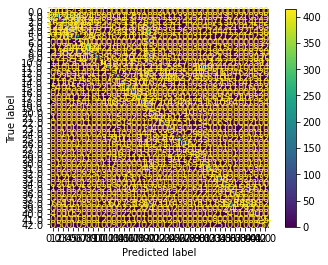

In [31]:
plot_confusion_matrix(svm, test_features, test_y)

In [23]:
import pickle

In [24]:
filename = 'kmeans_32.sav'
pickle.dump(bovw.cluster_model, open(filename, 'wb'))

In [19]:
print(classification_report(y_pred, test_y))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       0.00      0.20      0.00         5
         2.0       0.00      0.00      0.00        19
         3.0       0.02      0.18      0.04        56
         4.0       0.07      0.60      0.13        78
         5.0       0.12      0.33      0.18       233
         6.0       0.01      0.07      0.01        15
         7.0       0.06      0.60      0.11        45
         8.0       0.01      0.05      0.01        55
         9.0       0.00      0.50      0.00         2
        10.0       0.04      0.93      0.08        29
        11.0       0.00      0.00      0.00        10
        12.0       0.85      0.05      0.10     10727
        13.0       0.05      0.85      0.09        40
        14.0       0.00      0.00      0.00         0
        15.0       0.04      0.27      0.07        33
        16.0       0.07      0.79      0.13        14
        17.0       0.03    

In [42]:
y_pred[:10]

array([32.,  0., 36., 11., 39.,  2.,  7.,  2., 19.,  7.], dtype=float32)

In [43]:
test_y[:10]

array(['32', '1', '13', '11', '38', '2', '7', '2', '19', '7'], dtype='<U2')

In [50]:
from skimage.feature import hog

In [51]:
train_hog = []
for image in train_X:
    fd, hog_image = hog(image, orientations=8, pixels_per_cell=(16, 16),
                        cells_per_block=(1, 1), visualize=True, multichannel=True)
    train_hog.append(hog_image.reshape(-1))
    

In [ ]:
linear_svm_hog = SVC(kernel='linear', C=1, decision_function_shape='ovo', verbose=True).fit(train_hog, train_y)

[LibSVM]

In [ ]:
test_hog = []
for image in train_X:
    fd, hog_image = hog(image, orientations=8, pixels_per_cell=(16, 16),
                        cells_per_block=(1, 1), visualize=True, multichannel=True)
    test_hog.append(hog_image.reshape(-1))

In [ ]:
y_pred_hog = linear_svm.predict(test_hog)

In [ ]:
print(classification_report(y_pred_hog, test_y))

In [62]:
sift = cv2.xfeatures2d.SIFT_create(contrastThreshold = 0.02, sigma = 1.2, edgeThreshold = 20)

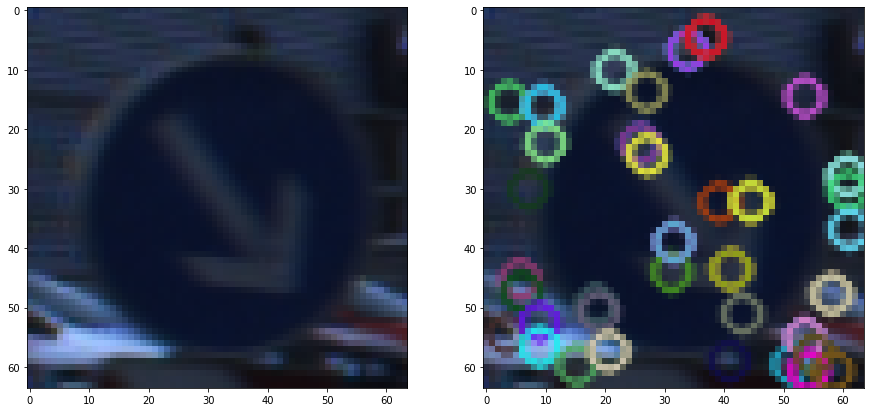

In [63]:
test_img = test_X[4]
keypoints, descriptors = sift.detectAndCompute(test_img, None)
showInRow([test_img, cv2.drawKeypoints(test_img, keypoints, test_img.copy())])